# 필수 라이브러리 Import

In [118]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import torch
import torchvision
import torch.nn as nn
from torchinfo import summary
from torchvision import datasets, models
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torchvision.utils import make_grid

# 데이터 불러오기

In [27]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Dataset path:", path)

Dataset path: /Users/carki/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [28]:
train_dir = os.path.join(path, "chest_xray", "train")
val_dir = os.path.join(path, "chest_xray", "val")
test_dir = os.path.join(path, "chest_xray", "test")

# GPU 설정

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# 데이터 전처리

In [30]:

transforms = v2.Compose(
    [
        v2.Resize((224, 224)),
        v2.ToImage(),
        v2.ToDtype(dtype=torch.float32, scale=True),
    ]
)

# 데이터셋 로드
train_dataset = datasets.ImageFolder(train_dir, transform=transforms)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 클래스 확인
class_names = train_dataset.classes
print("Class names:", class_names)

Class names: ['NORMAL', 'PNEUMONIA']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.3668411].


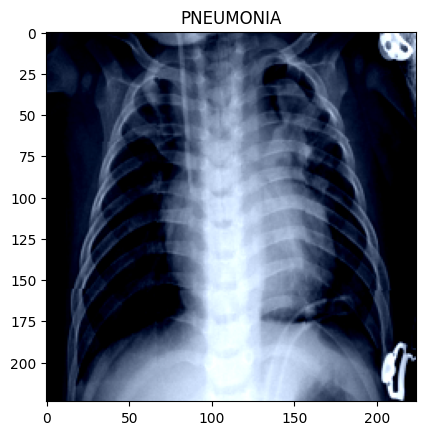

In [57]:
# 데이터 로더에서 배치 가져오기 (train)
images, labels = next(iter(train_loader))

# 이미지를 디스플레이
def imshow(img, title):
    img = img / 2 + 0.5  # 정규화 복원
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

# 첫 번째 배치의 첫 번째 이미지 시각화
imshow(images[0], title=class_names[labels[0]])

## 데이터 전처리 정의

In [44]:
def data_transforms(phase = None):
    if phase == 'train':
        data_T = v2.Compose([
                v2.Resize(size = (256,256)),
                v2.RandomRotation(degrees = (-20,+20)),
                v2.CenterCrop(size=224),
                v2.ToTensor(),
                v2.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
    
    elif phase == 'test' or phase == 'val':
        data_T = v2.Compose([
                v2.Resize(size = (224,224)),
                v2.ToTensor(),
                v2.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
        
    return data_T

## Load Data Sets

In [58]:
# 데이터셋 로드
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms('train'))
val_dataset = datasets.ImageFolder(val_dir, data_transforms('val'))
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms('test'))

class_names = train_dataset.classes

print(class_names)
print(train_dataset.class_to_idx)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

['NORMAL', 'PNEUMONIA']
{'NORMAL': 0, 'PNEUMONIA': 1}
Number of training samples: 5216
Number of validation samples: 16
Number of test samples: 624


/Users/carki/Desktop/Dev/codeit/codeit/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


## Class Count Plot

In [49]:
def plot_class_count(classes,name = None):
    pd.DataFrame(
        classes,columns = [name]
    ).groupby(
        [classes]
    ).size(
    ).plot(
        kind = 'bar',
        title = name
    )

    plt.show()

In [50]:
def get_class_count(dataset,name = None):
    classes = []
    for _,label in dataset:
        if label == 0:
            classes.append(class_names[label])
            
        elif label == 1:
            classes.append(class_names[label])
            
    return classes

### Train Class Count

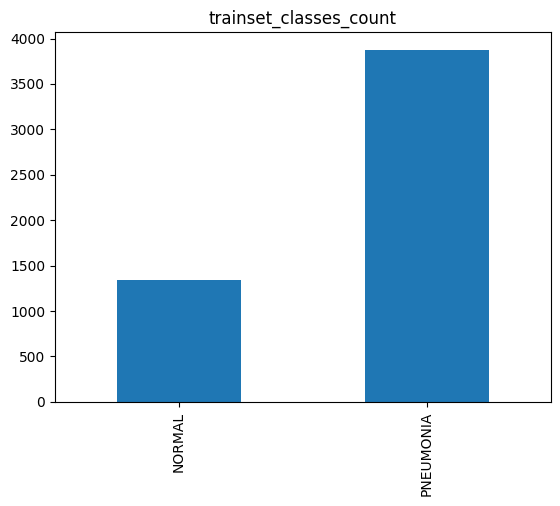

In [51]:
trainset_class_count = get_class_count(train_dataset,name = 'trainset_classes_count')
plot_class_count(trainset_class_count,name = 'trainset_classes_count')

### Test Class Count

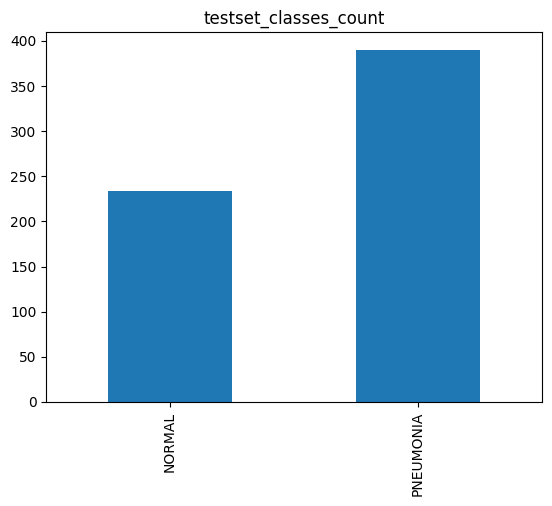

In [52]:
testset_class_count = get_class_count(test_dataset,name = 'testset_classes_count')
plot_class_count(testset_class_count,name = 'testset_classes_count')

### Valid Class Count

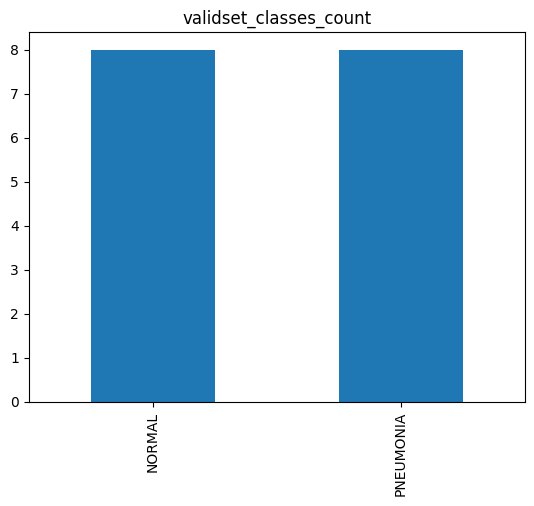

In [53]:
validset_class_count = get_class_count(val_dataset,name = 'validset_classes_count')
plot_class_count(validset_class_count,name = 'validset_classes_count')

## Loading Dataset into batches

In [59]:
# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Plot Images

In [96]:
def show_images_with_titles(images, labels, class_names, nrow=5, figsize=(15, 10)):
    batch_size = images.shape[0]
    ncol = nrow
    nrow = (batch_size + ncol - 1) // ncol

    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])

    plt.figure(figsize=figsize)

    for idx in range(batch_size):
        img = images[idx].clone().detach().cpu()
        img = img.permute(1, 2, 0)
        img = (img * std) + mean
        img = torch.clamp(img, 0, 1).numpy()

        label_text = class_names[labels[idx]]

        ax = plt.subplot(nrow, ncol, idx + 1)
        ax.imshow(img)
        ax.set_title(label_text, fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


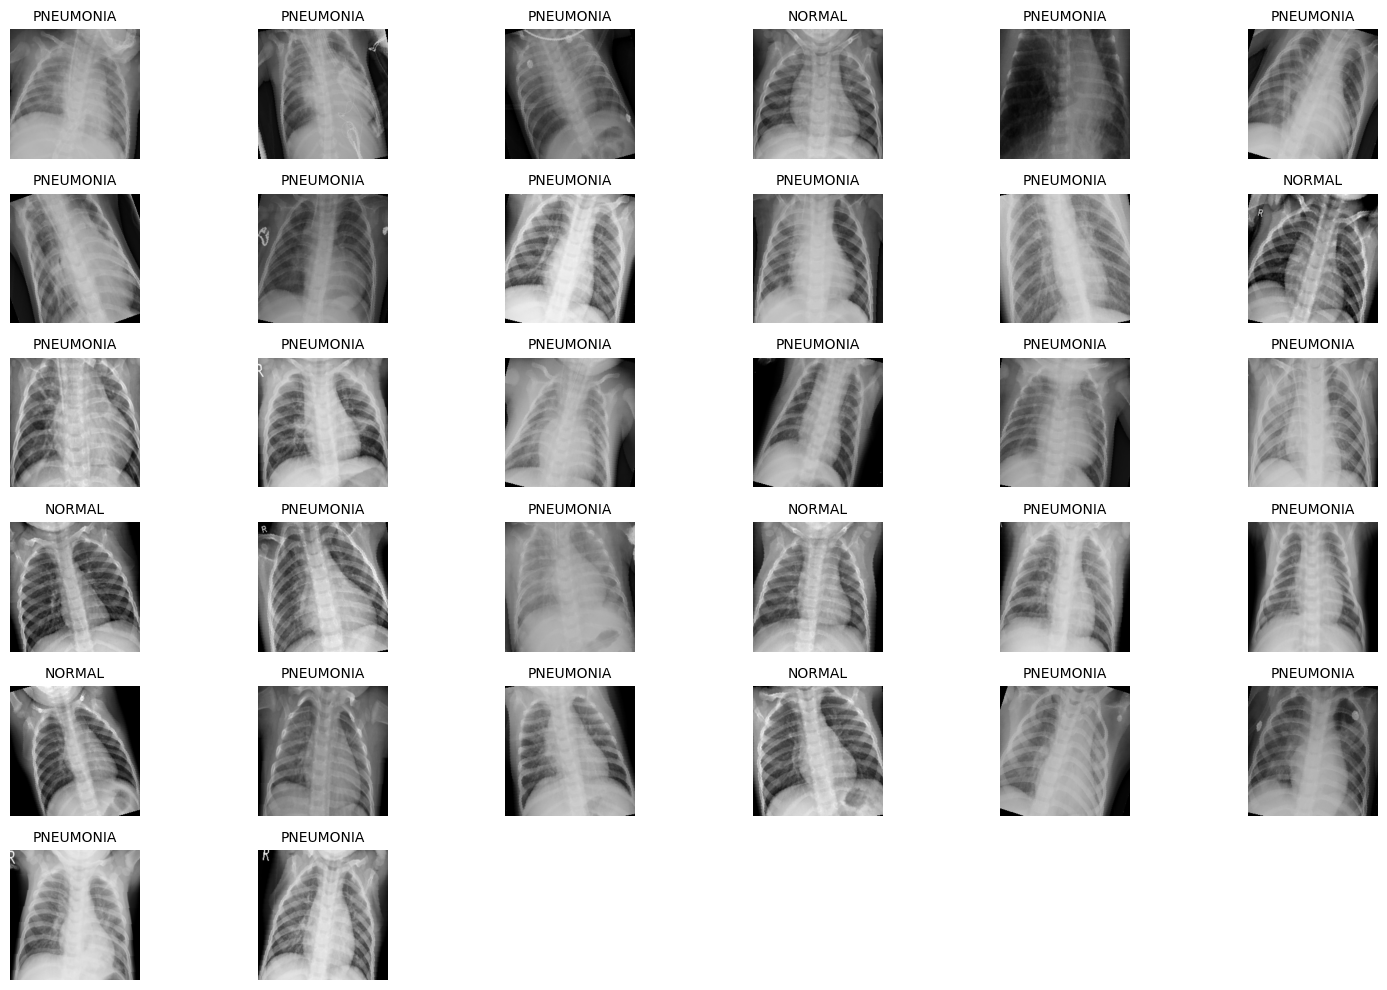

torch.Size([32, 3, 224, 224])


In [106]:
images, labels = next(iter(train_loader))

# ["NORMAL", "PNEUMONIA"]
show_images_with_titles(images, labels, class_names=class_names, nrow=6)

print(images.shape)


# [Modeling] VGG-16 

In [116]:
model = models.vgg16_bn(weights='VGG16_BN_Weights.IMAGENET1K_V1')

result = summary(model=model, input_size=(32, 3, 224, 224), device=device)

print(result)

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [32, 1000]                --
├─Sequential: 1-1                        [32, 512, 7, 7]           --
│    └─Conv2d: 2-1                       [32, 64, 224, 224]        1,792
│    └─BatchNorm2d: 2-2                  [32, 64, 224, 224]        128
│    └─ReLU: 2-3                         [32, 64, 224, 224]        --
│    └─Conv2d: 2-4                       [32, 64, 224, 224]        36,928
│    └─BatchNorm2d: 2-5                  [32, 64, 224, 224]        128
│    └─ReLU: 2-6                         [32, 64, 224, 224]        --
│    └─MaxPool2d: 2-7                    [32, 64, 112, 112]        --
│    └─Conv2d: 2-8                       [32, 128, 112, 112]       73,856
│    └─BatchNorm2d: 2-9                  [32, 128, 112, 112]       256
│    └─ReLU: 2-10                        [32, 128, 112, 112]       --
│    └─Conv2d: 2-11                      [32, 128, 112, 112]       147,

In [119]:
model.classifier[6] = nn.Linear(4096, 2)            # 1000→2 클래스로 교체
model = model.to(device)

In [120]:
crit = nn.CrossEntropyLoss()
optim = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)  # AdamW: decoupled WD [oai_citation:7‡docs.pytorch.org](https://docs.pytorch.org/tutorials/beginner/transfer_learning_tutorial.html?utm_source=chatgpt.com)
sched = torch.optim.lr_scheduler.StepLR(optim, step_size=5, gamma=0.1) # 학습률 스케줄러: 5 epoch마다 lr를 1/10로 감소
                                                                       # → 초반에는 빠르게 학습하고, 일정 단계 이후에는 작은 lr로 미세 조정

# Training

In [121]:
from tqdm.auto import tqdm

train_acc_hist, val_acc_hist = [], []
EPOCHS = 10
for epoch in range(EPOCHS):
    # ---- Train ----
    model.train()
    corr = tot = 0
    for x,y in tqdm(train_loader, desc=f"E{epoch+1}/{EPOCHS}"):
        x,y = x.to(device), y.to(device)
        optim.zero_grad()
        out = model(x)
        loss = crit(out, y)
        loss.backward()
        optim.step()
        corr += (out.argmax(1)==y).sum().item()
        tot  += y.size(0)
    train_acc_hist.append(corr/tot)

    # ---- Val ----
    model.eval(); corr = tot = 0
    with torch.no_grad():
        for x,y in val_loader:
            x,y = x.to(device), y.to(device)
            out = model(x)
            corr += (out.argmax(1)==y).sum().item()
            tot  += y.size(0)
    val_acc_hist.append(corr/tot)
    print(f"[{epoch+1}] train:{train_acc_hist[-1]:.3f}  val:{val_acc_hist[-1]:.3f}")
    sched.step()

E1/10:   2%|▏         | 4/163 [00:56<37:35, 14.19s/it]


KeyboardInterrupt: 

In [ ]:
# --- 1) 학습·검증 정확도 그래프 ---
plt.figure(figsize=(6,4))
plt.plot(train_acc_hist, label="Train")
plt.plot(val_acc_hist,   label="Val")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.ylim(0,1)
plt.title("VGG16 TL — Cat·Dog Accuracy")
plt.legend(); plt.show()

# --- 2) 간단 뷰어 (예측 vs 실제) ---
import random
model.eval()
samples = random.sample(range(len(val_ds)), 6)
fig, axes = plt.subplots(2,3, figsize=(9,6))
for ax, idx in zip(axes.flatten(), samples):
    img, label = val_ds[idx]
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device)).argmax(1).item()
    ax.imshow(img.permute(1,2,0).mul(torch.tensor(IMG_STD)).add(torch.tensor(IMG_MEAN)).clamp(0,1))
    ax.set_title(f"P:{'Dog' if pred else 'Cat'} / T:{'Dog' if label else 'Cat'}",
                 color=("g" if pred==label else "r"))
    ax.axis("off")
plt.tight_layout(); plt.show()